In [207]:
# 7/22/21: https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

# end cite


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [208]:
import json
import os
from os.path import join, exists

import pandas as pd
import matplotlib.pyplot as plt

In [209]:
from utils import load_models, transformers_bert_completions, split_gen
from utils_child import child_models
import config

In [210]:
import importlib
importlib.reload(load_models)

<module 'utils.load_models' from '/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/utils/load_models.py'>

In [271]:
config.model_dir

'/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/goal_to_convergence/models'

## Analyze model hyperparameter results

## new setup with all of the models

In [ ]:
paths = [
    split_gen.get_split_folder('all', 'all', config.model_dir),
    split_gen.get_split_folder('age', 'young', config.model_dir),
    split_gen.get_split_folder('age', 'old', config.model_dir)
]

for path in paths:
    
    for tags in [True, False]:

        tag_str =  "with_tags" if tags else "no_tags"

        with open(join(path, join(tag_str, 'trainer_state.json')), 'r') as f:

            gen_dict = json.load(f)
            this_history = gen_dict['log_history'] # the save step was too sparse basically, so you can't tell what the training curve is like
            # This probably means that vagrant + wandb is worth setting up?

            epochs = []; losses = []

            for step_dict in this_history[:-1]: # Omit summary stats
                #if 'loss' not in step_dict: continue
                if 'eval_loss' not in step_dict: continue
                epochs.append(step_dict['epoch'])
                losses.append(step_dict['eval_loss'])
                #else:
                #    losses.append(step_dict['eval_loss'])

                # The training rate is too high -- so try 0.001
                
            train_epochs = []; train_losses = []
            for step_dict in this_history[:-1]: # Omit summary stats
                #if 'loss' not in step_dict: continue
                if 'loss' not in step_dict: continue
                train_epochs.append(step_dict['epoch'])
                train_losses.append(step_dict['loss'])

            this_step = gen_dict['best_model_checkpoint'].split('/')[-1]
            dataset_name = '/'.join(path.split('/')[-3:]) + f'{tag_str} | step: {this_step}' + f"/{gen_dict['global_step']}"

        plt.title(f'{dataset_name}')
        plt.xlabel('epoch'); plt.ylabel('loss')
        plt.plot(epochs, losses, label = 'val')
        plt.plot(train_epochs, train_losses, label = 'train')

        plt.legend(); plt.show()
        # This is somewhat better? Does not log the first epoch though?
        # Compare eval_results across the different models?


        # it seems that the fit for the other models is still better
        # and that hyperparam manual search is difficult?
        
        # Seems like with tags is ~convergence but the loss is quite high?
        # Whereas the no_tags is not to convergence,
        # is possible you should search them separately + then rerun?
        
        # For age/old/no_tags it is at converngece
        
        
# The training loss is NOT indicative of the goodness of the val loss -- what to do?
# You should launch some kind of separately hyperparam tuning for each of these 
# on like 25% of the data
# or even the 1000 examples

# the learning rate is too high -- what to do?
# need to plot eval_loss more frequently
# is it worth launching the small search if it was misleading last time?


## new setup

[{'epoch': 1.04, 'learning_rate': 0.0006981327800829875, 'loss': 5.7145, 'step': 500}, {'epoch': 1.04, 'eval_loss': 5.656787395477295, 'eval_runtime': 13.2716, 'eval_samples_per_second': 71.205, 'step': 500}, {'epoch': 2.07, 'learning_rate': 0.0006462655601659752, 'loss': 5.6417, 'step': 1000}, {'epoch': 2.07, 'eval_loss': 5.655313968658447, 'eval_runtime': 13.3056, 'eval_samples_per_second': 71.023, 'step': 1000}, {'epoch': 3.11, 'learning_rate': 0.0005943983402489627, 'loss': 5.6303, 'step': 1500}, {'epoch': 3.11, 'eval_loss': 5.6505560874938965, 'eval_runtime': 13.2749, 'eval_samples_per_second': 71.187, 'step': 1500}, {'epoch': 4.15, 'learning_rate': 0.0005425311203319502, 'loss': 5.622, 'step': 2000}, {'epoch': 4.15, 'eval_loss': 5.6352057456970215, 'eval_runtime': 13.2729, 'eval_samples_per_second': 71.198, 'step': 2000}, {'epoch': 5.19, 'learning_rate': 0.0004906639004149378, 'loss': 5.6197, 'step': 2500}, {'epoch': 5.19, 'eval_loss': 5.6448516845703125, 'eval_runtime': 13.2736,

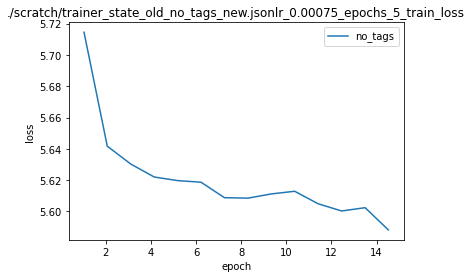

In [269]:
path = './scratch/trainer_state_old_no_tags_new.json'

for tags in [False]:
    
    tag_str =  "with_tags" if tags else "no_tags"

    with open(path, 'r') as f:

        this_history = json.load(f)['log_history'] # the save step was too sparse basically, so you can't tell what the training curve is like
        # This probably means that vagrant + wandb is worth setting up?
        
        print(this_history)

        epochs = []; losses = []

        for step_dict in this_history[:-1]: # Omit summary stats
            if 'loss' not in step_dict: continue
            epochs.append(step_dict['epoch'])
            losses.append(step_dict['loss'])
            #else:
            #    losses.append(step_dict['eval_loss'])
            
            # The training rate is too high -- so try 0.001
        
        dataset_name = '/'.join(path.split('/')[-3:]) + 'lr_0.00075_epochs_5_train_loss'

    plt.title(f'{dataset_name}')
    plt.xlabel('epoch'); plt.ylabel('loss')
    plt.plot(epochs, losses, label = tag_str)

    plt.legend(); plt.show()
    # This is somewhat better? Does not log the first epoch though?
    # Compare eval_results across the different models?
    
    
    # it seems that the fit for the other models is still better
    # and that hyperparam manual search is difficult?

# lr = 0.0075 examples

[{'epoch': 0.8, 'learning_rate': 0.00063, 'loss': 3.5949, 'step': 100}, {'epoch': 1.6, 'learning_rate': 0.00051, 'loss': 2.9275, 'step': 200}, {'epoch': 2.4, 'learning_rate': 0.00039000000000000005, 'loss': 2.7027, 'step': 300}, {'epoch': 3.2, 'learning_rate': 0.00027, 'loss': 2.4866, 'step': 400}, {'epoch': 4.0, 'learning_rate': 0.00015000000000000001, 'loss': 2.2871, 'step': 500}, {'epoch': 4.0, 'eval_loss': 2.5342154502868652, 'eval_runtime': 38.6371, 'eval_samples_per_second': 25.882, 'step': 500}, {'epoch': 4.8, 'learning_rate': 3e-05, 'loss': 2.0992, 'step': 600}, {'epoch': 5.0, 'step': 625, 'total_flos': 336427923456000.0, 'train_runtime': 621.0821, 'train_samples_per_second': 1.006}]


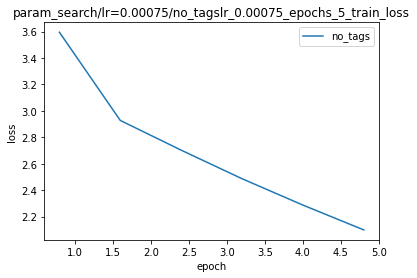

In [266]:
path = '/home/nwong/child_repo/experiments/param_search/lr=0.00075/no_tags'

for tags in [False]:
    
    tag_str =  "with_tags" if tags else "no_tags"

    with open(join(path, 'trainer_state.json'), 'r') as f:

        this_history = json.load(f)['log_history'] # the save step was too sparse basically, so you can't tell what the training curve is like
        # This probably means that vagrant + wandb is worth setting up?
        
        print(this_history)

        epochs = []; losses = []

        for step_dict in this_history[:-1]: # Omit summary stats
            if 'loss' not in step_dict: continue
            epochs.append(step_dict['epoch'])
            losses.append(step_dict['loss'])
            #else:
            #    losses.append(step_dict['eval_loss'])
            
            # The training rate is too high -- so try 0.001
        
        dataset_name = '/'.join(path.split('/')[-3:]) + 'lr_0.00075_epochs_5_train_loss'

    plt.title(f'{dataset_name}')
    plt.xlabel('epoch'); plt.ylabel('loss')
    plt.plot(epochs, losses, label = tag_str)

    plt.legend(); plt.show()
    # This is somewhat better? Does not log the first epoch though?
    # Compare eval_results across the different models?
    

## lr = 0.001, 1000 examples

[{'epoch': 0.8, 'learning_rate': 0.00084, 'loss': 5.9724, 'step': 100}, {'epoch': 1.6, 'learning_rate': 0.00068, 'loss': 5.5891, 'step': 200}, {'epoch': 2.4, 'learning_rate': 0.0005200000000000001, 'loss': 5.5656, 'step': 300}, {'epoch': 3.2, 'learning_rate': 0.00035999999999999997, 'loss': 5.5597, 'step': 400}, {'epoch': 4.0, 'learning_rate': 0.0002, 'loss': 5.5455, 'step': 500}, {'epoch': 4.0, 'eval_loss': 5.689082145690918, 'eval_runtime': 38.5828, 'eval_samples_per_second': 25.918, 'step': 500}]


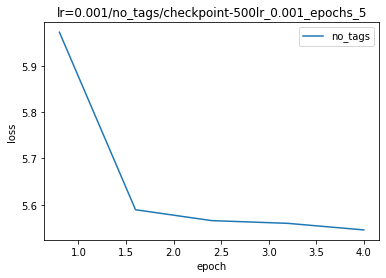

In [263]:
# Do you need to search for the other models? Probably not, topim is likely similar.

path = 'experiments/param_search/lr=0.001/no_tags/checkpoint-500'

for tags in [False]:
    
    tag_str =  "with_tags" if tags else "no_tags"

    with open(join(path, 'trainer_state.json'), 'r') as f:

        this_history = json.load(f)['log_history'] # the save step was too sparse basically, so you can't tell what the training curve is like
        # This probably means that vagrant + wandb is worth setting up?
        
        print(this_history)

        epochs = []; losses = []

        for step_dict in this_history[:-1]: # Omit summary stats
            #if 'eval_loss' not in step_dict: continue
            epochs.append(step_dict['epoch'])
            losses.append(step_dict['loss'])
            #else:
            #    losses.append(step_dict['eval_loss'])
            
            # The training rate is too high -- so try 0.001
        
        dataset_name = '/'.join(path.split('/')[-3:]) + 'lr_0.001_epochs_5'

    plt.title(f'{dataset_name}')
    plt.xlabel('epoch'); plt.ylabel('loss')
    plt.plot(epochs, losses, label = tag_str)

    plt.legend(); plt.show()
    
    # However, prior learning rates were too slow? What to do?
    # You can train with lr = 0.001? But didn't you do this already?
    


## Even fewer examples, lr = 0.005

python3 run_mlm.py --train_file /om2/user/wongn/child-directed-listening/finetune/all/all/train_no_tags.txt --validation_file /om2/user/wongn/child-directed-listening/finetune/all/all/val_no_tags.txt --cache_dir ~/.cache/$SLURM_JOB_ID --output_dir /om2/user/wongn/child-directed-listening/experiments/param_search/lr=0.005/models/all/all/no_tags --do_eval  --do_train  --eval_steps 500 --evaluation_strategy steps --learning_rate 0.005 --load_best_model_at_end  --logging_steps 100 --logging_strategy steps --metric_for_best_model eval_loss --model_name_or_path bert-base-uncased --num_train_epochs 5 --overwrite_output_dir  --per_device_eval_batch_size 8 --per_device_train_batch_size 8 --save_steps 500 --save_strategy steps --save_total_limit 1 --max_train_samples 1000 --max_eval_samples 1000

[{'epoch': 0.8, 'learning_rate': 0.0042, 'loss': 6.8615, 'step': 100}, {'epoch': 1.6, 'learning_rate': 0.0034000000000000002, 'loss': 5.6008, 'step': 200}, {'epoch': 2.4, 'learning_rate': 0.0026000000000000003, 'loss': 5.5707, 'step': 300}, {'epoch': 3.2, 'learning_rate': 0.0018, 'loss': 5.5611, 'step': 400}, {'epoch': 4.0, 'learning_rate': 0.001, 'loss': 5.5471, 'step': 500}, {'epoch': 4.0, 'eval_loss': 5.6973161697387695, 'eval_runtime': 38.5516, 'eval_samples_per_second': 25.939, 'step': 500}, {'epoch': 4.8, 'learning_rate': 0.0002, 'loss': 5.5407, 'step': 600}, {'epoch': 5.0, 'step': 625, 'total_flos': 336427923456000.0, 'train_runtime': 617.7702, 'train_samples_per_second': 1.012}]


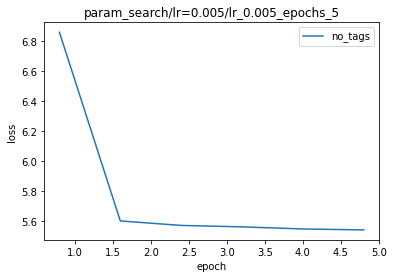

In [252]:
path = './experiments/param_search/lr=0.005/' # This is all,all,notags


for tags in [False]:
    
    tag_str =  "with_tags" if tags else "no_tags"

    with open(join(path, 'trainer_state.json'), 'r') as f:

        this_history = json.load(f)['log_history'] # the save step was too sparse basically, so you can't tell what the training curve is like
        # This probably means that vagrant + wandb is worth setting up?
        
        print(this_history)

        epochs = []; losses = []

        for step_dict in this_history[:-1]: # Omit summary stats
            #if 'eval_loss' not in step_dict: continue
            if 'loss' in step_dict:
                epochs.append(step_dict['epoch'])
                losses.append(step_dict['loss'])
            #else:
            #    losses.append(step_dict['eval_loss'])
            
            # The training rate is too high -- so try 0.001


        
        dataset_name = '/'.join(path.split('/')[-3:]) + 'lr_0.005_epochs_5'

    plt.title(f'{dataset_name}')
    plt.xlabel('epoch'); plt.ylabel('loss')
    plt.plot(epochs, losses, label = tag_str)

    plt.legend(); plt.show()
    


## Small number of examples, using lr = 0.0005

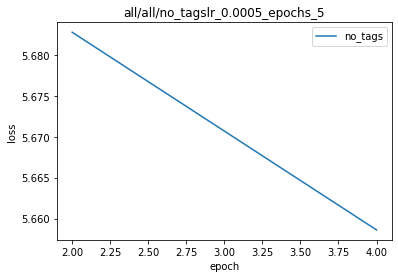


[2.0, 4.0]
[5.68278694152832, 5.658604621887207]


In [244]:
path = './experiments/param_search/lr=0.0005/models/all/all/no_tags'

for tags in [False]:
    
    tag_str =  "with_tags" if tags else "no_tags"

    with open(join(path, 'trainer_state.json'), 'r') as f:

        this_history = json.load(f)['log_history']

        epochs = []; losses = []

        for step_dict in this_history[:-1]: # Omit summary stats
            if 'eval_loss' not in step_dict: continue
            epochs.append(step_dict['epoch'])
            losses.append(step_dict['eval_loss'])


        
        dataset_name = '/'.join(path.split('/')[-3:]) + 'lr_0.0005_epochs_5'

    plt.title(f'{dataset_name}')
    plt.xlabel('epoch'); plt.ylabel('loss')
    plt.plot(epochs, losses, label = tag_str)

    plt.legend(); plt.show()
    
print()
 # Not sure if this implies either? Too slow or?

    # It's just bad optimization
    
print(epochs)
print(losses) # This was on more things...

## Incomplete search for lr=0.0075, no tags

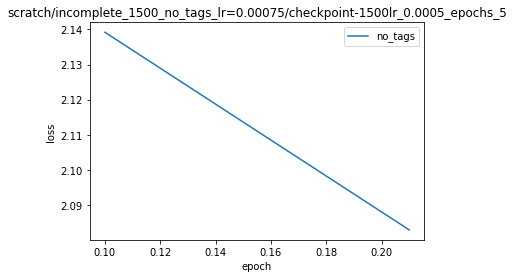

In [226]:
path = './scratch/incomplete_1500_no_tags_lr=0.00075/checkpoint-1500'

for tags in [False]:
    
    tag_str =  "with_tags" if tags else "no_tags"

    with open(join(path, 'trainer_state.json'), 'r') as f:

        this_history = json.load(f)['log_history']

        epochs = []; losses = []

        for step_dict in this_history[:-1]: # Omit summary stats
            if 'eval_loss' not in step_dict: continue
            epochs.append(step_dict['epoch'])
            losses.append(step_dict['eval_loss'])


        
        dataset_name = '/'.join(path.split('/')[-3:]) + 'lr_0.0005_epochs_5'

    plt.title(f'{dataset_name}')
    plt.xlabel('epoch'); plt.ylabel('loss')
    plt.plot(epochs, losses, label = tag_str)

    plt.legend(); plt.show()
    
print()
 # Not sure if this implies either? Too slow or?


[0.08, 0.16, 0.23, 0.31, 0.39, 0.47, 0.55, 0.63, 0.7, 0.78, 0.86, 0.94, 1.02, 1.09, 1.17, 1.25, 1.33, 1.41, 1.48, 1.56, 1.64, 1.72, 1.8, 1.88, 1.95, 2.03, 2.11, 2.19, 2.27, 2.34, 2.42, 2.5, 2.58, 2.66, 2.74, 2.81, 2.89, 2.97]


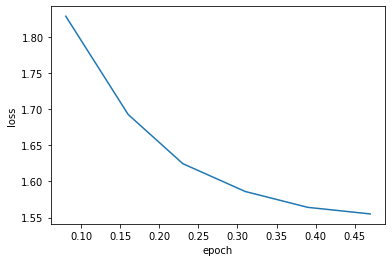

In [236]:
# check against what is really with_tags

path = f'/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/models/child/Naima/with_tags'
# This comparable y/n?

with open(join(path, 'trainer_state.json'), 'r') as f:
    
    this_history = json.load(f)['log_history']
    
    #print(this_history)

    epochs = []; losses = []

    for step_dict in this_history[:-1]: # Omit summary stats
        epochs.append(step_dict['epoch'])
        losses.append(step_dict['loss'])
        
    print(epochs)
        
        
plt.xlabel('epoch'); plt.ylabel('loss')
plt.plot(epochs[:6], losses[:6])
plt.show() # So the previous learning rate is still too low.
# Good to monitor this via? the wandb system? With interactive session instead?
# Should you write these to a specific location/otherwise automate this search.


## First set of all/all trained with the appropriate train/val checkpoints. Note: Incomplete optimization for no_tags (timed out on ~6 h run for 5 epochs).

## Load "classification" data

In [213]:
names = child_models.get_child_names()

In [211]:
split = 'all'; dataset = 'all';

this_split_loc = split_gen.get_split_folder(split, dataset, config.model_analyses_dir)
results_path = join(this_split_loc, 'completions_classification.csv')
this_df = pd.read_csv(results_path).reset_index()

this_df['index'] = list(range(this_df.shape[0]))
this_df.set_index('index')

has_chi = lambda s : '[CHI]' in s

this_df['pred_chi'] = (this_df['cgv_prob'] < this_df['chi_prob'])
this_df['has_chi'] = list(map(has_chi, this_df['sentence']))


## analyze tagless losses (with linebyline enabled, original with tags model)

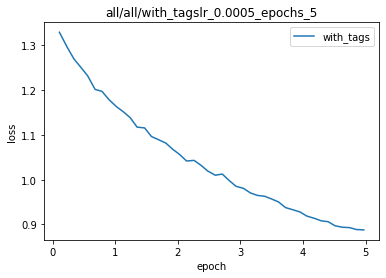

In [222]:
# Need to load the scores from the analyses -- do you want to score the entire subset?
# Probably sufficient for now to compare the subsample

# How to calculate the actual loss?

for tags in [True]:
    
    tag_str =  "with_tags" if tags else "no_tags"
    path = f'./experiments/retrain_with_val/all/all/{tag_str}'

    with open(join(path, 'trainer_state.json'), 'r') as f:

        this_history = json.load(f)['log_history']

        epochs = []; losses = []

        for step_dict in this_history[:-1]: # Omit summary stats
            if 'eval_loss' not in step_dict: continue
            epochs.append(step_dict['epoch'])
            losses.append(step_dict['eval_loss'])


        
        dataset_name = '/'.join(path.split('/')[-3:]) + 'lr_0.0005_epochs_5'

    plt.title(f'{dataset_name}')
    plt.xlabel('epoch'); plt.ylabel('loss')
    plt.plot(epochs, losses, label = tag_str)

    plt.legend(); plt.show()
    
print()

# The learning rate is too slow.
# Probably worth using some kind of accelerated search, or using... unsure
# probably better to take a small subset, figure out a good learning rate + monitor using wandb,
# and then iterate on the entire set



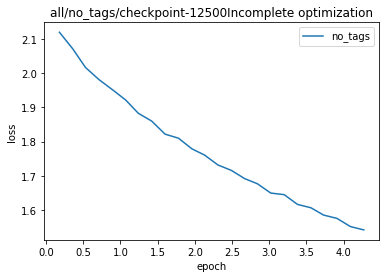

In [224]:
# Need to load the scores from the analyses -- do you want to score the entire subset?
# Probably sufficient for now to compare the subsample

# How to calculate the actual loss?


tags = False
tag_str =  "with_tags" if tags else "no_tags"
path = f'experiments/retrain_with_val/all/all/no_tags/checkpoint-12500'

with open(join(path, 'trainer_state.json'), 'r') as f:

    this_history = json.load(f)['log_history']

    epochs = []; losses = []

    for step_dict in this_history[:-1]: # Omit summary stats
        if 'eval_loss' not in step_dict: continue
        epochs.append(step_dict['epoch'])
        losses.append(step_dict['eval_loss'])



    dataset_name = '/'.join(path.split('/')[-3:]) + 'Incomplete optimization'

plt.title(f'{dataset_name}')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.plot(epochs, losses, label = tag_str)

plt.legend(); plt.show()

print() # The learning rate is too slow. Probably worth using a different rate/somehow searching more efficiently/
# enabling some kind of hyperparam search
# What else have you tried? 0.001 is too high?

# Make a hyperparam search set + look for something that exists and then train on like 3 epochs on not a lot of data
# find the best lr, then request higher memory?



## analyze child model behaviors

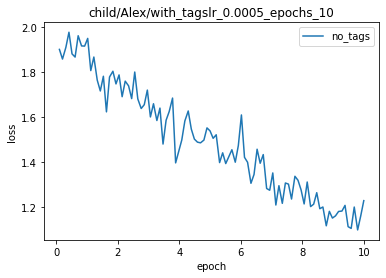

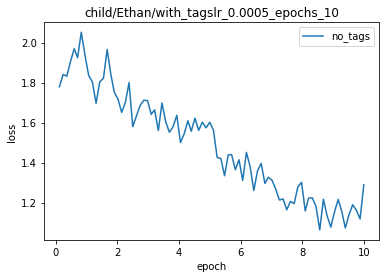

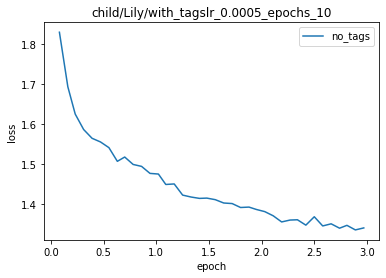

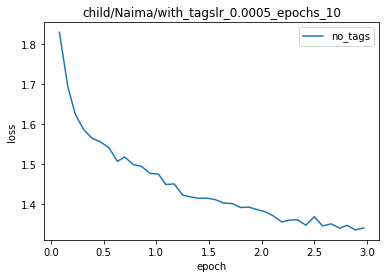

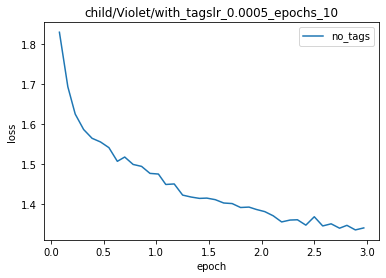

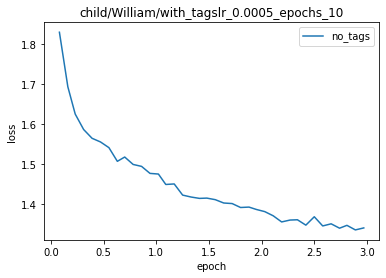

In [214]:
for name in names:
    
    path = f'/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/models/child/{name}/with_tags'


    with open(join(path, 'trainer_state.json'), 'r') as f:

        this_history = json.load(f)['log_history']

        epochs = []; losses = []

        for step_dict in this_history[:-1]: # Omit summary stats
            epochs.append(step_dict['epoch'])
            losses.append(step_dict['loss'])


        tag_str =  "with_tags" if tags else "no_tags"
        dataset_name = '/'.join(path.split('/')[-3:]) + 'lr_0.0005_epochs_10'

    plt.title(f'{dataset_name}')
    plt.xlabel('epoch'); plt.ylabel('loss')
    plt.plot(epochs, losses, label = tag_str)

    plt.legend(); plt.show()

    # the optimization is not very good, what to do?
    # this is a function of finetuning or something else?

    # perplexity of eval loss is high -- what does this mean?
    # does eval loss generally increase -- is it overfitting too much?
    # how to interpret the results?
    # what is initial evaluation score -- is it a bad optimization thing? 

    # If I visualize these results are they reflective of finetuning on Alex?
    # Should I increase the learning rate? Probably not?

## analyze 0.001 tagless full

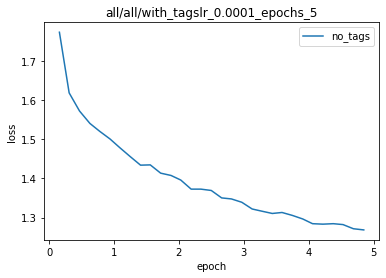

{'epoch': 5.0, 'eval_loss': 1.1783275604248047, 'eval_runtime': 323.4758, 'eval_samples': 12647, 'eval_samples_per_second': 39.097, 'perplexity': 3.2489360074744558}


In [200]:
# With tags training

path = '/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/scripts_train_lr_0.0001_epochs_5/models/all/all/with_tags'

with open(join(path, 'trainer_state.json'), 'r') as f:
    
    this_history = json.load(f)['log_history']

    epochs = []; losses = []

    for step_dict in this_history[:-1]: # Omit summary stats
        epochs.append(step_dict['epoch'])
        losses.append(step_dict['loss'])


    tag_str =  "with_tags" if tags else "no_tags"
    dataset_name = '/'.join(path.split('/')[-3:]) + 'lr_0.0001_epochs_5'

plt.title(f'{dataset_name}')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.plot(epochs, losses, label = tag_str)

plt.legend(); plt.show()

# 0.001 is slightly improved?

with open(join(path, 'eval_results.json')) as f:
    print(json.load(f))
    
    # There is higher perplexity overall, for longer training?
    # No, there is lower perplexity slightly (from ~4.0 or so)
    
    # Should you increase the learning rate/train for longer?
    # Unsure of what to do?
    # Increase the batch size and then train for longer?
    # Probably interim evaluate first
    
    # Important: need to visualize the loss curves if possible -- but overfitting is very unlikely
    # So yes 5e-4 is probably better?
    
    # Train 5e-4 for 5 epochs?
    

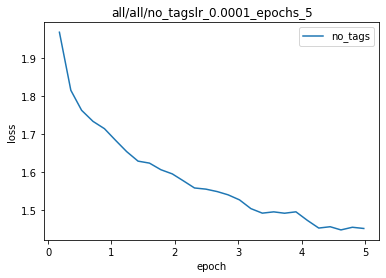

{'epoch': 5.0, 'eval_loss': 1.3477448225021362, 'eval_runtime': 284.2558, 'eval_samples': 11128, 'eval_samples_per_second': 39.148, 'perplexity': 3.84873615316752}


In [195]:
# No tags training

path = '/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/scripts_train_lr_0.0001_epochs_5/models/all/all/no_tags'

with open(join(path, 'trainer_state.json'), 'r') as f:
    
    this_history = json.load(f)['log_history']

    epochs = []; losses = []

    for step_dict in this_history[:-1]: # Omit summary stats
        epochs.append(step_dict['epoch'])
        losses.append(step_dict['loss'])


    tag_str =  "with_tags" if tags else "no_tags"
    dataset_name = '/'.join(path.split('/')[-3:]) + 'lr_0.0001_epochs_5'

plt.title(f'{dataset_name}')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.plot(epochs, losses, label = tag_str)

plt.legend(); plt.show()

# 0.001 is slightly improved?

with open(join(path, 'eval_results.json')) as f:
    print(json.load(f))
    
    # There is higher perplexity overall, for longer training?
    # No, there is lower perplexity slightly (from ~4.0 or so)
    
    # Should you increase the learning rate/train for longer?
    # Unsure of what to do?
    # Increase the batch size and then train for longer?
    # Probably interim evaluate first
    
    # Important: need to visualize the loss curves if possible -- but overfitting is very unlikely
    # 
    

In [198]:
glob.glob('/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/scripts_train_lr_0.0001_epochs_5/models/all/all/no_tags')

NameError: name 'glob' is not defined

## interim analyze lr = 0.001 -- note that last checkpoint was on 6000

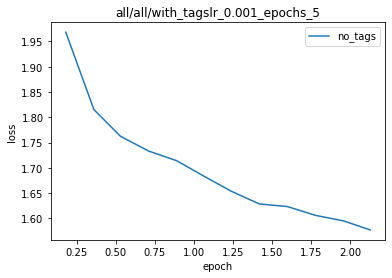

In [191]:
# If it's not evaluating at all in the middle then it can't be evaluating on the val metrics -- so you should really rerun all of the trainings
# If this is the case resplit may be worth it?


with open(join('./trainer_state.json'), 'r') as f:
    this_history = json.load(f)['log_history']

    epochs = []; losses = []

    for step_dict in this_history[:-1]: # Omit summary stats
        epochs.append(step_dict['epoch'])
        losses.append(step_dict['loss'])


    tag_str =  "with_tags" if tags else "no_tags"
    dataset_name = '/'.join(path.split('/')[-3:]) + 'lr_0.001_epochs_5'

plt.title(f'{dataset_name}')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.plot(epochs, losses, label = tag_str)

plt.legend(); plt.show()

#with open(join(model_path, 'eval_results.json'), 'r') as f:
#    print(json.load(f))
    
    # The training rate is a little bit low?
    # Maybe 5e-4 is really best?
    
    # Do you want to terminate and re-try this training?
    # Figure out the examples work first -- the train curve may not be as informative
    # check if there's a significant difference in perplexity?


## analyze lr = 0.001, epochs = 5 models all/all split

In [181]:
# Is this train loss or val loss? The evaluation perplexity was very very high -- why?
no_tags = './experiments/scripts_train_lr_0.001_epochs_5/models/all/all/no_tags'
#analyze_losses_path(no_tags)

# This checkpoint is 28000 -- so it has reached optimization
# that probably means that this is really a train loss plot, not a val loss plot
# double check this

# this was training 31500 step
# global step: 31990, so it reached some kind of convergence @ this point already

# that means that the plots are probably for train loss
# but it also means, 

with_tags = './experiments/scripts_train_lr_0.001_epochs_5/models/all/all/with_tags'
#analyze_losses_path(with_tags)

# Check whether these models improved at all in terms of the token?



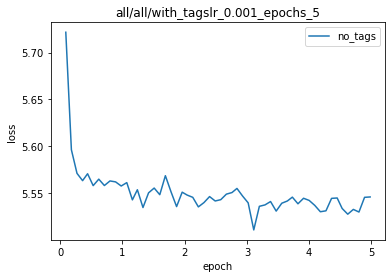

{'epoch': 5.0, 'eval_loss': 5.548198699951172, 'eval_runtime': 432.8589, 'eval_samples': 11128, 'eval_samples_per_second': 25.708, 'perplexity': 256.77461096031345}


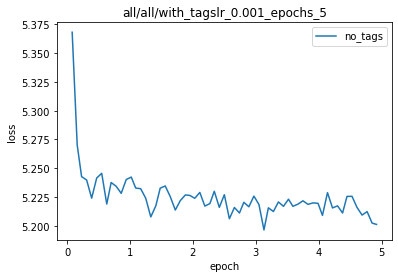

{'epoch': 5.0, 'eval_loss': 5.227954864501953, 'eval_runtime': 462.3537, 'eval_samples': 12647, 'eval_samples_per_second': 27.354, 'perplexity': 186.41117729859081}


In [186]:
paths = [
    no_tags,
    with_tags
]
for model_path in paths:
    with open(join(model_path, 'trainer_state.json'), 'r') as f:
        this_history = json.load(f)['log_history']

        epochs = []; losses = []

        for step_dict in this_history[:-1]: # Omit summary stats
            epochs.append(step_dict['epoch'])
            losses.append(step_dict['loss'])


        tag_str =  "with_tags" if tags else "no_tags"
        dataset_name = '/'.join(path.split('/')[-3:]) + 'lr_0.001_epochs_5'

    plt.title(f'{dataset_name}')
    plt.xlabel('epoch'); plt.ylabel('loss')
    plt.plot(epochs, losses, label = tag_str)

    plt.legend(); plt.show()
    
    with open(join(model_path, 'eval_results.json'), 'r') as f:
        print(json.load(f))
    
# This has already hit convergence?
# But it's possilbe this is just oscillation?
# Compare to the last one
# Does huggingface have a better lr system to auto search for this?

# in general 0.001 may be too steep

# Compare the eval results -- do they suggest overfitting ? Is it possible to overfit because of the selection of the 
# parameters + make sure it's really val?

# why is perplexity so high?
# does it have overall train loss?
# no it's posislbe this is just bad training

## Analyze Alex model to see if huggingface config is bad

In [163]:


def analyze_losses(split, dataset, tags):
    
    model_path = load_models.get_model_path(split, dataset, tags)
    
    with open(join(model_path, 'trainer_state.json'), 'r') as f:
        this_history = json.load(f)['log_history']

        epochs = []; losses = []

        for step_dict in this_history[:-1]: # Omit summary stats
            epochs.append(step_dict['epoch'])
            losses.append(step_dict['loss'])


        tag_str =  "with_tags" if tags else "no_tags"
        dataset_name = '/'.join((split, dataset))

    plt.title(f'{dataset_name}')
    plt.xlabel('epoch'); plt.ylabel('loss')
    plt.plot(epochs, losses, label = tag_str)
    plt.legend(); plt.show()
    


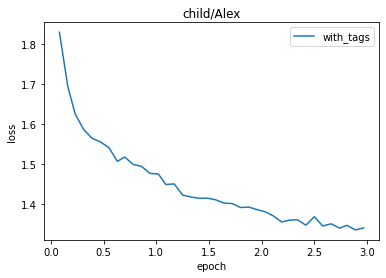

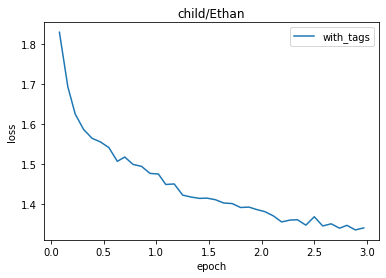

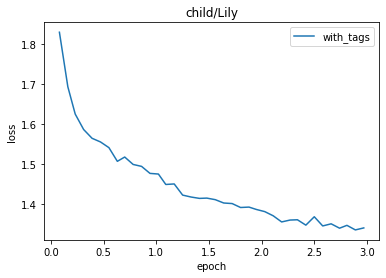

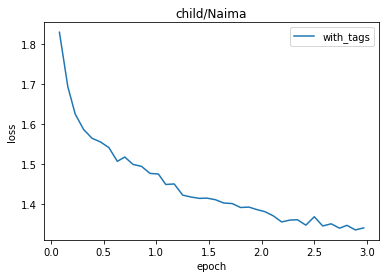

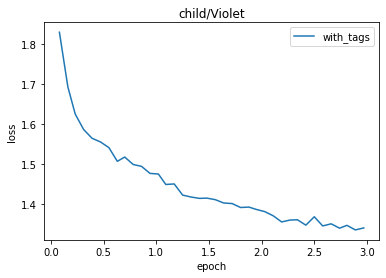

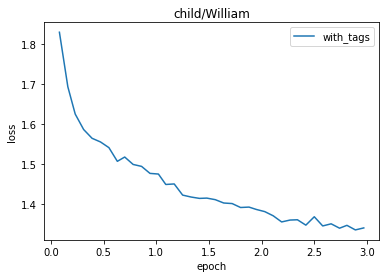

In [167]:
for name in child_models.get_child_names():
    
    _, is_tags = child_models.get_best_child_base_model_path()
    analyze_losses('child', name, is_tags)

# It's mostly converged so the arguments are ok -- 

# Are the models actually different at all/

## True vs predicted CHI CGV

In [135]:
sum(this_df['pred_chi']) # The number of pred chi predictions?

102

In [136]:
this_df.shape[0] - sum(this_df['pred_chi']) # The number of pred chi predictions?

398

In [139]:
this_df.columns

Index(['index', 'Unnamed: 0', 'cgv_prob', 'chi_prob', 'sentence', 'pred_chi',
       'has_chi'],
      dtype='object')

In [144]:
print('Predicted CGV, Actual CGV', this_df[~this_df.pred_chi & ~this_df.has_chi].shape[0])
print('Predicted CGV, Actual CHI', this_df[~this_df.pred_chi & this_df.has_chi].shape[0])
print('Predicted CHI, Actual CGV', this_df[this_df.pred_chi & ~this_df.has_chi].shape[0])
print('Predicted CHI, Actual CHI', this_df[~this_df.pred_chi & ~this_df.has_chi].shape[0])


Predicted CGV, Actual CGV 272
Predicted CGV, Actual CHI 126
Predicted CHI, Actual CGV 28
Predicted CHI, Actual CHI 272


In [128]:
import sklearn

print('Rows are true class')
print('Columns are predicted class')

matrix = sklearn.metrics.confusion_matrix(this_df['has_chi'], this_df['pred_chi'])

print(matrix)

print('Pred cgv, actual cgv', matrix[0][0])
print('Pred cgv, actual chi', matrix[0][1])
print()
print('Pred cgv, actual chi', matrix[1][0])
print('Pred chi, actual chi', matrix[1][1])

#plt.imshow(matrix)

#plt.xlabel('True class')
#plt.ylabel('Predicted class')

print()

# What to do here?

# But which is which? How to visualize this betteR?

Rows are true class
Columns are predicted class
[[272  28]
 [126  74]]
Pred cgv, actual cgv 272
Pred cgv, actual chi 28

Pred cgv, actual chi 126
Pred chi, actual chi 74



## Tokens with for lowest CHI CGV probabilities

In [111]:
def find_lowest_probs(is_chi, df, sel_num = 20):

    key = 'chi_prob' if is_chi else 'cgv_prob'
    lowest_idxs = np.argsort(df[key])[:sel_num]

    lowest_df = df[df.index.isin(lowest_idxs)]
    
    assert sorted(this_df[key])[:20] == sorted(lowest_df[key])
    
    return lowest_df
    
print('For lowest chi probs')
find_lowest_probs(True, this_df)

For lowest chi probs


,index,Unnamed: 0,cgv_prob,chi_prob,sentence,pred_chi,has_chi
25,25,25,0.002576,0.001355,[CGV] baby baby bunting.\n,False,False
29,29,29,0.034245,0.003258,[CGV] but she's just a little bit frightened s...,False,False
97,97,97,0.005801,0.000815,[CGV] is he?\n,False,False
109,109,109,0.014832,0.002243,[CGV] kinda big isn't it?\n,False,False
110,110,110,0.002429,0.001963,[CGV] knock knock.\n,False,False
179,179,179,0.336306,0.005173,[CGV] shall we go and put some socks and your ...,False,False
198,198,198,0.089450,0.003867,[CGV] that's the best way isn't it?\n,False,False
204,204,204,0.005158,0.001540,[CGV] then grover put his pajamas under his pi...,False,False
208,208,208,0.045346,0.001102,[CGV] they finish eating?\n,False,False
216,216,216,0.006541,0.003221,[CGV] tyres are made of...\n,False,False


In [112]:

print('For lowest cgv probs')
find_lowest_probs(False, this_df)

For lowest cgv probs


,index,Unnamed: 0,cgv_prob,chi_prob,sentence,pred_chi,has_chi
25,25,25,0.002576,0.001355,[CGV] baby baby bunting.\n,False,False
29,29,29,0.034245,0.003258,[CGV] but she's just a little bit frightened s...,False,False
97,97,97,0.005801,0.000815,[CGV] is he?\n,False,False
104,104,104,0.008150,0.005261,[CGV] it this hair or what?\n,False,False
109,109,109,0.014832,0.002243,[CGV] kinda big isn't it?\n,False,False
110,110,110,0.002429,0.001963,[CGV] knock knock.\n,False,False
122,122,122,0.021163,0.006330,[CGV] many of those fairy tales ones some of t...,False,False
175,175,175,0.025346,0.021529,[CGV] round and around and around round round.\n,False,False
204,204,204,0.005158,0.001540,[CGV] then grover put his pajamas under his pi...,False,False
206,206,206,0.024110,0.011119,[CGV] there was a a german friend home of of m...,False,False


## Check training set distribution

In [85]:
has_chi = lambda s : '[CHI]' in s

val_file_all_all = split_gen.get_split_folder('all', 'all', config.finetune_dir)

with open(join(val_file_all_all, 'val.txt'), 'r') as f:
    all_lines = f.readlines()
    
chi_lines = list(filter(has_chi, all_lines))
num_chi = len(chi_lines)
num_cgv = len(all_lines) - num_chi

print(f'Number of child in all/all split: {num_chi}')
print(f'Number of cgv in all/all split: {num_cgv}')

Number of child in all/all split: 317022
Number of cgv in all/all split: 461349


## Classification analysis code

In [46]:
# Dev mode
    
pred_chi = np.array(list(this_df['chi_prob'] > this_df['cgv_prob'])).astype('int')

accuracy = np.mean(pred_chi)

has_chi = lambda s : '[CHI]' in s
num_chi = len(list(filter(has_chi, this_df['sentence'])))

print('Accuracy at predicting labels', accuracy)
print()
print('Number of times that CHI is predicted', np.sum(pred_chi))
print(f'\tNumber of CHI tokens: {num_chi}')
print('Number of times that CGV is predicted', pred_chi.shape[0] - np.sum(pred_chi))
print(f'\tNumber of CGV tokens: {pred_chi.shape[0] - num_chi}')


Accuracy at predicting labels 0.204

Number of times that CHI is predicted 102
	Number of CHI tokens: 200
Number of times that CGV is predicted 398
	Number of CGV tokens: 300


In [86]:
398 / 500

0.796

In [52]:
# 2 Joint distributions
# 1) Joint distribution: 
# density plot -> x axis probability CGV, y axis probability CHI
# facet two panels -> one is true label cgv -> one is true label is cgv


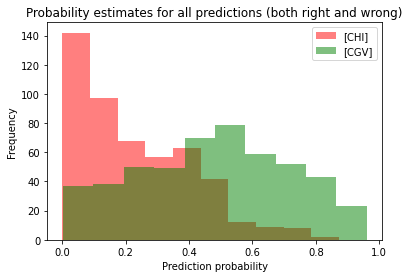

In [51]:

plt.title('Probability estimates for all predictions (both right and wrong)')

plt.xlabel('Prediction probability'); plt.ylabel('Frequency')
plt.hist(this_df['chi_prob'], color = 'r', alpha = 0.5, label = '[CHI]')
plt.hist(this_df['cgv_prob'], color = 'g', alpha = 0.5, label = '[CGV]')

plt.legend()

plt.show()

## Training process

{'epoch': 3.0, 'eval_loss': 1.2242496013641357, 'eval_runtime': 491.0377, 'eval_samples': 12647, 'eval_samples_per_second': 25.756, 'perplexity': 3.4016125594060935}
{'epoch': 3.0, 'eval_loss': 1.404678225517273, 'eval_runtime': 423.828, 'eval_samples': 11128, 'eval_samples_per_second': 26.256, 'perplexity': 4.074215551723496}


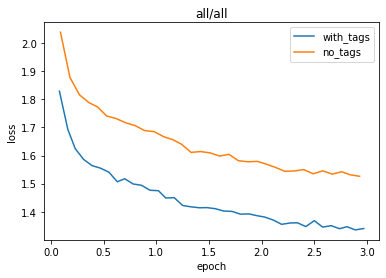

{'epoch': 3.0, 'eval_loss': 1.1556642055511475, 'eval_runtime': 299.1729, 'eval_samples': 7777, 'eval_samples_per_second': 25.995, 'perplexity': 3.1761323217964232}
{'epoch': 3.0, 'eval_loss': 1.3253873586654663, 'eval_runtime': 97.1765, 'eval_samples': 6797, 'eval_samples_per_second': 69.945, 'perplexity': 3.763642952386524}


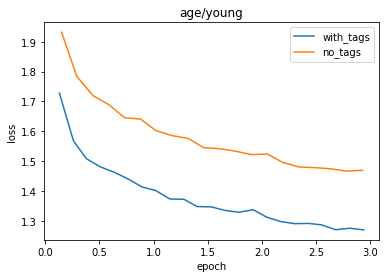

{'epoch': 3.0, 'eval_loss': 1.392958164215088, 'eval_runtime': 164.5041, 'eval_samples': 4291, 'eval_samples_per_second': 26.084, 'perplexity': 4.026744222529698}
{'epoch': 3.0, 'eval_loss': 1.5506988763809204, 'eval_runtime': 145.8454, 'eval_samples': 3810, 'eval_samples_per_second': 26.124, 'perplexity': 4.714764068696296}


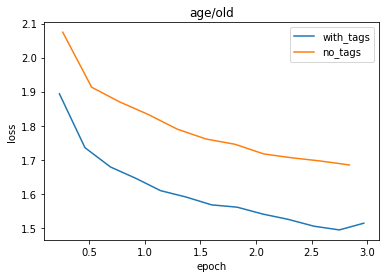

In [187]:
# Can read the results of models via trainer_state.json! 

# Intent is to figure out what is wrong with the tags fitting
# and why tags is worse -- is it overfitting?

# Also,
# Is model improving? What if we ran it for longer?
# What is happening to the loss

# Look at tags first

for arg_set in config.childes_model_args: # add children later
    
    for tags in [True, False]:
        model_path = load_models.get_model_path(arg_set[0], arg_set[1], tags)
        with open(join(model_path, 'trainer_state.json'), 'r') as f:
            this_history = json.load(f)['log_history']
            
            epochs = []; losses = []
            
            for step_dict in this_history[:-1]: # Omit summary stats
                epochs.append(step_dict['epoch'])
                losses.append(step_dict['loss'])
            
            
            tag_str =  "with_tags" if tags else "no_tags"
            dataset_name = '/'.join(arg_set)
            
            plt.title(f'{dataset_name}')
            plt.xlabel('epoch'); plt.ylabel('loss')
            plt.plot(epochs, losses, label = tag_str)
            
        with open(join(model_path, 'eval_results.json'), 'r') as f:
            print(json.load(f))
            
    plt.legend(); plt.show()
    
    # these are definitely not convergence

## Tag completions

In [13]:
## Building code in advance

def analyze_completions(sentences, model, tokenizer, softmax_mask):
    
    sentence_results = {}
    
    for sentence_type, sentence in sentences.items():
        _, completions = transformers_bert_completions.bert_completions(sentence, model, tokenizer, softmax_mask)
        sentence_results[sentence_type] = completions
        
    return sentence_results
    
chi_sentence = "[CHI] I want to [MASK]."
cgv_sentence = "[CGV] I want to [MASK]."

pred_chi = "[MASK] I want to go to the zoo."
pred_cgv = "[MASK] I want to go to the store."

sentences = {
    'chi_complete' : chi_sentence,
    'cgv_complete' : cgv_sentence,
    'pred_chi' : pred_chi,
    'pred_cgv' : pred_cgv,
}


In [55]:
initial_vocab_mask

array([ 1037,  1038,  1039, ..., 29588, 29593, 29594])

In [22]:
tag_model.keys()

dict_keys(['title', 'kwargs', 'type'])

In [59]:
print(initial_tokenizer.convert_tokens_to_ids(['[chi]']))
print(initial_tokenizer.convert_tokens_to_ids(['[cgv]']))

[30522]
[30523]


In [14]:

import numpy as np

# For future use
split = 'age'; dataset = 'old'
tag_model = load_models.get_finetune_dict(split, dataset, True, 20)['kwargs']['modelLM']


initial_tokenizer = load_models.get_primary_tokenizer()

cmu_2syl_inchildes = load_models.get_cmu_dict_info()
    
initial_vocab_mask, _ = transformers_bert_completions.get_softmax_mask(initial_tokenizer,
    cmu_2syl_inchildes.word)


analysis_args = {
    'model' : tag_model,
    'tokenizer' : initial_tokenizer,
    'softmax_mask' : np.concatenate([initial_vocab_mask, np.array([30522, 30523])]),
}

In [41]:
from pprint import pprint

pprint(sentences)

{'cgv_complete': '[CGV] I want to [MASK].',
 'chi_complete': '[CHI] I want to [MASK].',
 'pred_cgv': '[MASK] I want to go to the store.',
 'pred_chi': '[MASK] I want to go to the zoo.'}


In [15]:
results = analyze_completions(sentences = sentences, **analysis_args)

# Index out of range of self? Why?
# Because the adult model is not adjusted to the ? What tokenizer is typically used?
# It's because of the UNKs probably it (xxx, yyy) should be converted to UNK. 
# Is this expected behavior?

# How is this typically handled -- Adult BERT never receives tags so this is expected.



In [16]:
which_pred = 'pred_chi'

which_df = results[which_pred]
sel_df = which_df[which_df['word'] == '[chi]']

print(which_df[which_df['word'] == '[chi]'])
print(which_df[which_df['word'] == '[cgv]'])


          prob   word  rank
7904  0.599197  [chi]     0
          prob   word  rank
7905  0.111233  [cgv]     1


In [18]:
which_df[which_df['word'] == '[chi]']['prob']

0.5991969704627991

In [67]:
which_pred = 'pred_cgv'

which_df = results[which_pred]

print(which_df.head(5))

sel_df = which_df[which_df['word'] == '[cgv]']

print(sel_df)



          prob   word  rank
7904  0.461573  [chi]     0
7905  0.126699  [cgv]     1
8     0.075225      i     2
80    0.044257     no     3
630   0.030567     oh     4
          prob   word  rank
7905  0.126699  [cgv]     1


In [46]:
sentence = "[CHI] [MASK] want to go to the zoo."

_, completions = transformers_bert_completions.bert_completions(sentence, tag_model, initial_tokenizer, initial_vocab_mask)
completions.head(10)
        
    

,prob,word,rank
8,0.932832,i,0
45,0.018377,you,1
84,0.005512,we,2
6651,0.004383,mommy,3
55,0.003034,they,4
31,0.002964,he,5
61,0.002316,me,6
44,0.002181,she,7
3504,0.001653,daddy,8
3475,0.001067,um,9


In [47]:
sentence = "[CGV] [MASK] want to go to the zoo."

_, completions = transformers_bert_completions.bert_completions(sentence, tag_model, initial_tokenizer, initial_vocab_mask)
completions.head(10)
        
    

,prob,word,rank
45,0.483504,you,0
8,0.419221,i,1
55,0.039663,they,2
84,0.018343,we,3
31,0.004134,he,4
128,0.002974,people,5
102,0.002243,do,6
44,0.001907,she,7
53,0.001725,not,8
63,0.001631,all,9


In [72]:
from utils import load_splits

all_tokens = load_splits.load_phono()

In [96]:
all_tokens[all_tokens.partition == 'success'].iloc[10000:100020]

,token,utterance_id,gloss,transcript_id,utterance_order,target_child_name,speaker_code,type,punct,speaker_code_simple,...,cv_collapsed,num_vowels,in_vocab,success_token,yyy_token,partition,phase_sample,year,phase_child_sample,phase_child_finetune
226652,no,16802424,no,42221,713,Alex,CHI,declarative,.,[CHI],...,cv,1.0,True,True,False,success,eval,2.0,val,val
226660,the,16802426,the fruit,42238,1280,Alex,CHI,declarative,.,[CHI],...,cv,1.0,True,True,False,success,eval,2.5,val,val
226661,fruit,16802426,the fruit,42238,1280,Alex,CHI,declarative,.,[CHI],...,cv,1.0,True,True,False,success,eval,2.5,val,val
226684,that,16802432,what's that,42229,65,Alex,CHI,question,?,[CHI],...,cv,1.0,True,True,False,success,train,2.0,eval,NaN
226707,the,16802437,the bag,42241,180,Alex,CHI,declarative,.,[CHI],...,cv,1.0,True,True,False,success,eval,2.5,train,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760827,belong,17036478,where do they belong,42410,484,Naima,CHI,question,?,[CHI],...,cvcvc,2.0,True,True,False,success,eval,1.5,val,val
1760830,eat,17036479,eat some sesame,42412,1072,Naima,CHI,declarative,.,[CHI],...,vc,1.0,True,True,False,success,eval,1.5,train,train
1760831,some,17036479,eat some sesame,42412,1072,Naima,CHI,declarative,.,[CHI],...,cvc,1.0,True,True,False,success,eval,1.5,train,train
1760879,might,17036484,might be a she,42405,1114,Naima,CHI,declarative,.,[CHI],...,cv,1.0,True,True,False,success,eval,1.5,train,train


In [ ]:

this_id = 17036479
results_with_tags = transformers_bert_completions.get_stats_for_success(
    all_tokens, this_id, tag_model, initial_tokenizer, analysis_args['softmax_mask'], context_width_in_utts=3, use_speaker_labels=True
)

results_without_tags = transformers_bert_completions.get_stats_for_success(
    all_tokens, this_id, tag_model, initial_tokenizer, analysis_args['softmax_mask'], context_width_in_utts=20, use_speaker_labels=False
)

print('without')
print([df.head(10) for df in results_without_tags[1]][-1])

print(); print('with')
print([df.head(10) for df in results_with_tags[1]][-1])

In [ ]:
get_stats_for_success(all_tokens, selected_utt_id)